# Multi-Class Classification Model for Egyptian HCV Patients Using Python Take 1
### David Lowe
### February 6, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Egyptian HCV Patients dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset captured the Egyptian patients who underwent treatment dosages for HCV for about 18 months. The goal is to predict the patient's condition, in stages, based on the available measurements.

In this iteration, we will construct machine learning models with some simple and straight-forward data preparation steps. This model will serve as the baseline for the future iterations of modeling.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 25.85%. Two algorithms (k-Nearest Neighbors and Random Forest) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, k-Nearest Neighbors turned in the top overall result and achieved an accuracy metric of 29.48%. By using the optimized parameters, the Bagged Decision Trees algorithm processed the testing dataset with an accuracy of 24.78%, which was no better than the prediction from the training data.

CONCLUSION: For this iteration, the k-Nearest Neighbors algorithm achieved the best overall results using the training and test datasets, but all algorithms performed poorly. For this dataset, we should consider applying more feature engineering techniques to the dataset before performing further modeling.

Dataset Used: Hepatitis C Virus (HCV) for Egyptian patients Data Set

Dataset ML Model: Multi-Class classification with numerical attributes

Dataset Reference: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. https://archive.ics.uci.edu/ml/datasets/Hepatitis+C+Virus+%28HCV%29+for+Egyptian+patients

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

Using TensorFlow backend.


### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 10

# Set various default modeling parameters
scoring = 'accuracy'

In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_path = 'https://dainesanalytics.com/datasets/py-classification-egyptian-hcv-patients/HCV-Egy-Data.csv'
Xy_original = pd.read_csv(dataset_path, sep=',')

# Strip the whitespaces from the dataframe header
Xy_original.rename(columns=lambda x: x.strip(), inplace=True)

# Take a peek at the dataframe after import
Xy_original.head(10)

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,Baselinehistological staging
0,56,1,35,2,1,1,1,2,2,2,...,5,5,5,655330,634536,288194,5,5,13,2
1,46,1,29,1,2,2,1,2,2,1,...,57,123,44,40620,538635,637056,336804,31085,4,2
2,57,1,33,2,2,2,2,1,1,1,...,5,5,5,571148,661346,5,735945,558829,4,4
3,49,2,33,1,2,1,2,1,2,1,...,48,77,33,1041941,449939,585688,744463,582301,10,3
4,59,1,32,1,1,2,1,2,2,2,...,94,90,30,660410,738756,3731527,338946,242861,11,1
5,58,2,22,2,2,2,1,2,2,1,...,73,114,29,1157452,1086852,5,5,5,4,4
6,42,2,26,1,1,2,2,2,2,2,...,84,80,28,325694,1034008,275095,214566,635157,12,4
7,48,2,30,1,1,2,2,1,1,2,...,96,53,39,641129,72050,787295,370605,506296,12,3
8,44,1,23,1,1,2,2,2,1,2,...,122,39,45,591441,757361,5,371090,203042,5,2
9,45,1,30,2,1,2,2,1,1,2,...,125,43,30,1151206,230488,267320,275295,555516,4,2


In [8]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 29 columns):
Age                                1385 non-null int64
Gender                             1385 non-null int64
BMI                                1385 non-null int64
Fever                              1385 non-null int64
Nausea/Vomting                     1385 non-null int64
Headache                           1385 non-null int64
Diarrhea                           1385 non-null int64
Fatigue & generalized bone ache    1385 non-null int64
Jaundice                           1385 non-null int64
Epigastric pain                    1385 non-null int64
WBC                                1385 non-null int64
RBC                                1385 non-null float64
HGB                                1385 non-null int64
Plat                               1385 non-null float64
AST 1                              1385 non-null int64
ALT 1                              1385 non-null int64
ALT4     

In [9]:
Xy_original.describe()

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,Baselinehistological staging
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1.385000e+03,1.385000e+03,1.385000e+03,1385.000000,1385.000000,1385.000000,1385.000000
mean,46.319134,1.489531,28.608664,1.515523,1.502527,1.496029,1.502527,1.498917,1.501083,1.503971,...,83.117690,83.629603,33.438267,5.909512e+05,6.008956e+05,2.887536e+05,287660.336462,291378.290975,9.761733,2.536462
std,8.781506,0.500071,4.076215,0.499939,0.500174,0.500165,0.500174,0.500179,0.500179,0.500165,...,26.399031,26.223955,7.073569,3.539354e+05,3.623151e+05,2.853507e+05,264559.525070,267700.691713,4.023896,1.121392
min,32.000000,1.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,5.000000,5.000000,1.100000e+01,5.000000e+00,5.000000e+00,5.000000,5.000000,3.000000,1.000000
25%,39.000000,1.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,61.000000,61.000000,28.000000,2.692530e+05,2.708930e+05,5.000000e+00,5.000000,5.000000,6.000000,2.000000
50%,46.000000,1.000000,29.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,...,84.000000,83.000000,34.000000,5.931030e+05,5.978690e+05,2.343590e+05,251376.000000,244049.000000,10.000000,3.000000
75%,54.000000,2.000000,32.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,106.000000,106.000000,40.000000,8.867910e+05,9.090930e+05,5.248190e+05,517806.000000,527864.000000,13.000000,4.000000
max,61.000000,2.000000,35.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,128.000000,128.000000,45.000000,1.201086e+06,1.201715e+06,3.731527e+06,808450.000000,810333.000000,16.000000,4.000000


In [10]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Age                                0
Gender                             0
BMI                                0
Fever                              0
Nausea/Vomting                     0
Headache                           0
Diarrhea                           0
Fatigue & generalized bone ache    0
Jaundice                           0
Epigastric pain                    0
WBC                                0
RBC                                0
HGB                                0
Plat                               0
AST 1                              0
ALT 1                              0
ALT4                               0
ALT 12                             0
ALT 24                             0
ALT 36                             0
ALT 48                             0
ALT after 24 w                     0
RNA Base                           0
RNA 4                              0
RNA 12                             0
RNA EOT                            0
RNA EF                             0
B

### 1.d) Data Cleaning

In [11]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'Baselinehistological staging': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['column1','column2','column3'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['col_name'].fillna(value=Xy_original['col_name'].median(), inplace=True)

# Convert columns from one data type to another
categorical_columns = ['Gender','Fever','Nausea/Vomting','Headache','Diarrhea','Fatigue & generalized bone ache',
                       'Jaundice','Epigastric pain','Baseline histological Grading','targetVar']
Xy_original[categorical_columns] = Xy_original[categorical_columns].astype('category')

integer_columns = Xy_original.select_dtypes(include=['int']).columns
Xy_original[integer_columns] = Xy_original[integer_columns].astype('float')

# Convert features with 1/0 levels into categorical feature of Y/N
# def reClassSomecol(code):
#     if (code == 1): return 'Y'
#     else: return 'N'
# Xy_original['targetVar] = Xy_original['targetVar'].apply(reClassSomecol)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,targetVar
0,56.0,1,35.0,2,1,1,1,2,2,2,...,5.0,5.0,5.0,655330.0,634536.0,288194.0,5.0,5.0,13,2
1,46.0,1,29.0,1,2,2,1,2,2,1,...,57.0,123.0,44.0,40620.0,538635.0,637056.0,336804.0,31085.0,4,2
2,57.0,1,33.0,2,2,2,2,1,1,1,...,5.0,5.0,5.0,571148.0,661346.0,5.0,735945.0,558829.0,4,4
3,49.0,2,33.0,1,2,1,2,1,2,1,...,48.0,77.0,33.0,1041941.0,449939.0,585688.0,744463.0,582301.0,10,3
4,59.0,1,32.0,1,1,2,1,2,2,2,...,94.0,90.0,30.0,660410.0,738756.0,3731527.0,338946.0,242861.0,11,1
5,58.0,2,22.0,2,2,2,1,2,2,1,...,73.0,114.0,29.0,1157452.0,1086852.0,5.0,5.0,5.0,4,4
6,42.0,2,26.0,1,1,2,2,2,2,2,...,84.0,80.0,28.0,325694.0,1034008.0,275095.0,214566.0,635157.0,12,4
7,48.0,2,30.0,1,1,2,2,1,1,2,...,96.0,53.0,39.0,641129.0,72050.0,787295.0,370605.0,506296.0,12,3
8,44.0,1,23.0,1,1,2,2,2,1,2,...,122.0,39.0,45.0,591441.0,757361.0,5.0,371090.0,203042.0,5,2
9,45.0,1,30.0,2,1,2,2,1,1,2,...,125.0,43.0,30.0,1151206.0,230488.0,267320.0,275295.0,555516.0,4,2


In [12]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 29 columns):
Age                                1385 non-null float64
Gender                             1385 non-null category
BMI                                1385 non-null float64
Fever                              1385 non-null category
Nausea/Vomting                     1385 non-null category
Headache                           1385 non-null category
Diarrhea                           1385 non-null category
Fatigue & generalized bone ache    1385 non-null category
Jaundice                           1385 non-null category
Epigastric pain                    1385 non-null category
WBC                                1385 non-null float64
RBC                                1385 non-null float64
HGB                                1385 non-null float64
Plat                               1385 non-null float64
AST 1                              1385 non-null float64
ALT 1                         

In [13]:
Xy_original.describe()

,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,ALT4,ALT 12,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF
count,1385.000000,1385.000000,1385.000000,1.385000e+03,1385.000000,1385.00000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1.385000e+03,1.385000e+03,1.385000e+03,1385.000000,1385.000000
mean,46.319134,28.608664,7533.386282,4.422130e+06,12.587726,158348.06065,82.774729,83.916245,83.405776,83.510469,83.709025,83.117690,83.629603,33.438267,5.909512e+05,6.008956e+05,2.887536e+05,287660.336462,291378.290975
std,8.781506,4.076215,2668.220333,3.463577e+05,1.713511,38794.78555,25.993242,25.922800,26.529730,26.064478,26.205994,26.399031,26.223955,7.073569,3.539354e+05,3.623151e+05,2.853507e+05,264559.525070,267700.691713
min,32.000000,22.000000,2991.000000,3.816422e+06,10.000000,93013.00000,39.000000,39.000000,39.000000,39.000000,39.000000,5.000000,5.000000,5.000000,1.100000e+01,5.000000e+00,5.000000e+00,5.000000,5.000000
25%,39.000000,25.000000,5219.000000,4.121374e+06,11.000000,124479.00000,60.000000,62.000000,61.000000,60.000000,61.000000,61.000000,61.000000,28.000000,2.692530e+05,2.708930e+05,5.000000e+00,5.000000,5.000000
50%,46.000000,29.000000,7498.000000,4.438465e+06,13.000000,157916.00000,83.000000,83.000000,82.000000,84.000000,83.000000,84.000000,83.000000,34.000000,5.931030e+05,5.978690e+05,2.343590e+05,251376.000000,244049.000000
75%,54.000000,32.000000,9902.000000,4.721279e+06,14.000000,190314.00000,105.000000,106.000000,107.000000,106.000000,107.000000,106.000000,106.000000,40.000000,8.867910e+05,9.090930e+05,5.248190e+05,517806.000000,527864.000000
max,61.000000,35.000000,12101.000000,5.018451e+06,15.000000,226464.00000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,45.000000,1.201086e+06,1.201715e+06,3.731527e+06,808450.000000,810333.000000


In [14]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Age                                0
Gender                             0
BMI                                0
Fever                              0
Nausea/Vomting                     0
Headache                           0
Diarrhea                           0
Fatigue & generalized bone ache    0
Jaundice                           0
Epigastric pain                    0
WBC                                0
RBC                                0
HGB                                0
Plat                               0
AST 1                              0
ALT 1                              0
ALT4                               0
ALT 12                             0
ALT 24                             0
ALT 36                             0
ALT 48                             0
ALT after 24 w                     0
RNA Base                           0
RNA 4                              0
RNA 12                             0
RNA EOT                            0
RNA EF                             0
B

### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [15]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [16]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (1385, 29) X_original.shape: (1385, 28) y_original.shape: (1385,)


### 1.f) Set up the parameters for data visualization

In [17]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [18]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [19]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [20]:
X_original.head(10)

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,...,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading
0,56.0,1,35.0,2,1,1,1,2,2,2,...,81.0,5.0,5.0,5.0,655330.0,634536.0,288194.0,5.0,5.0,13
1,46.0,1,29.0,1,2,2,1,2,2,1,...,113.0,57.0,123.0,44.0,40620.0,538635.0,637056.0,336804.0,31085.0,4
2,57.0,1,33.0,2,2,2,2,1,1,1,...,116.0,5.0,5.0,5.0,571148.0,661346.0,5.0,735945.0,558829.0,4
3,49.0,2,33.0,1,2,1,2,1,2,1,...,88.0,48.0,77.0,33.0,1041941.0,449939.0,585688.0,744463.0,582301.0,10
4,59.0,1,32.0,1,1,2,1,2,2,2,...,120.0,94.0,90.0,30.0,660410.0,738756.0,3731527.0,338946.0,242861.0,11
5,58.0,2,22.0,2,2,2,1,2,2,1,...,65.0,73.0,114.0,29.0,1157452.0,1086852.0,5.0,5.0,5.0,4
6,42.0,2,26.0,1,1,2,2,2,2,2,...,107.0,84.0,80.0,28.0,325694.0,1034008.0,275095.0,214566.0,635157.0,12
7,48.0,2,30.0,1,1,2,2,1,1,2,...,45.0,96.0,53.0,39.0,641129.0,72050.0,787295.0,370605.0,506296.0,12
8,44.0,1,23.0,1,1,2,2,2,1,2,...,97.0,122.0,39.0,45.0,591441.0,757361.0,5.0,371090.0,203042.0,5
9,45.0,1,30.0,2,1,2,2,1,1,2,...,81.0,125.0,43.0,30.0,1151206.0,230488.0,267320.0,275295.0,555516.0,4


#### 2.a.ii) Dimensions and attribute types

In [21]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 28 columns):
Age                                1385 non-null float64
Gender                             1385 non-null category
BMI                                1385 non-null float64
Fever                              1385 non-null category
Nausea/Vomting                     1385 non-null category
Headache                           1385 non-null category
Diarrhea                           1385 non-null category
Fatigue & generalized bone ache    1385 non-null category
Jaundice                           1385 non-null category
Epigastric pain                    1385 non-null category
WBC                                1385 non-null float64
RBC                                1385 non-null float64
HGB                                1385 non-null float64
Plat                               1385 non-null float64
AST 1                              1385 non-null float64
ALT 1                         

#### 2.a.iii) Statistical summary of the attributes

In [22]:
X_original.describe()

,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,ALT4,ALT 12,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF
count,1385.000000,1385.000000,1385.000000,1.385000e+03,1385.000000,1385.00000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1.385000e+03,1.385000e+03,1.385000e+03,1385.000000,1385.000000
mean,46.319134,28.608664,7533.386282,4.422130e+06,12.587726,158348.06065,82.774729,83.916245,83.405776,83.510469,83.709025,83.117690,83.629603,33.438267,5.909512e+05,6.008956e+05,2.887536e+05,287660.336462,291378.290975
std,8.781506,4.076215,2668.220333,3.463577e+05,1.713511,38794.78555,25.993242,25.922800,26.529730,26.064478,26.205994,26.399031,26.223955,7.073569,3.539354e+05,3.623151e+05,2.853507e+05,264559.525070,267700.691713
min,32.000000,22.000000,2991.000000,3.816422e+06,10.000000,93013.00000,39.000000,39.000000,39.000000,39.000000,39.000000,5.000000,5.000000,5.000000,1.100000e+01,5.000000e+00,5.000000e+00,5.000000,5.000000
25%,39.000000,25.000000,5219.000000,4.121374e+06,11.000000,124479.00000,60.000000,62.000000,61.000000,60.000000,61.000000,61.000000,61.000000,28.000000,2.692530e+05,2.708930e+05,5.000000e+00,5.000000,5.000000
50%,46.000000,29.000000,7498.000000,4.438465e+06,13.000000,157916.00000,83.000000,83.000000,82.000000,84.000000,83.000000,84.000000,83.000000,34.000000,5.931030e+05,5.978690e+05,2.343590e+05,251376.000000,244049.000000
75%,54.000000,32.000000,9902.000000,4.721279e+06,14.000000,190314.00000,105.000000,106.000000,107.000000,106.000000,107.000000,106.000000,106.000000,40.000000,8.867910e+05,9.090930e+05,5.248190e+05,517806.000000,527864.000000
max,61.000000,35.000000,12101.000000,5.018451e+06,15.000000,226464.00000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,45.000000,1.201086e+06,1.201715e+06,3.731527e+06,808450.000000,810333.000000


#### 2.a.iv) Summarize the levels of the class attribute

In [23]:
Xy_original.groupby('targetVar').size()

targetVar
1    336
2    332
3    355
4    362
dtype: int64

### 2.b) Data Visualization

##### 2.b.i) Univariate plots to better understand each attribute

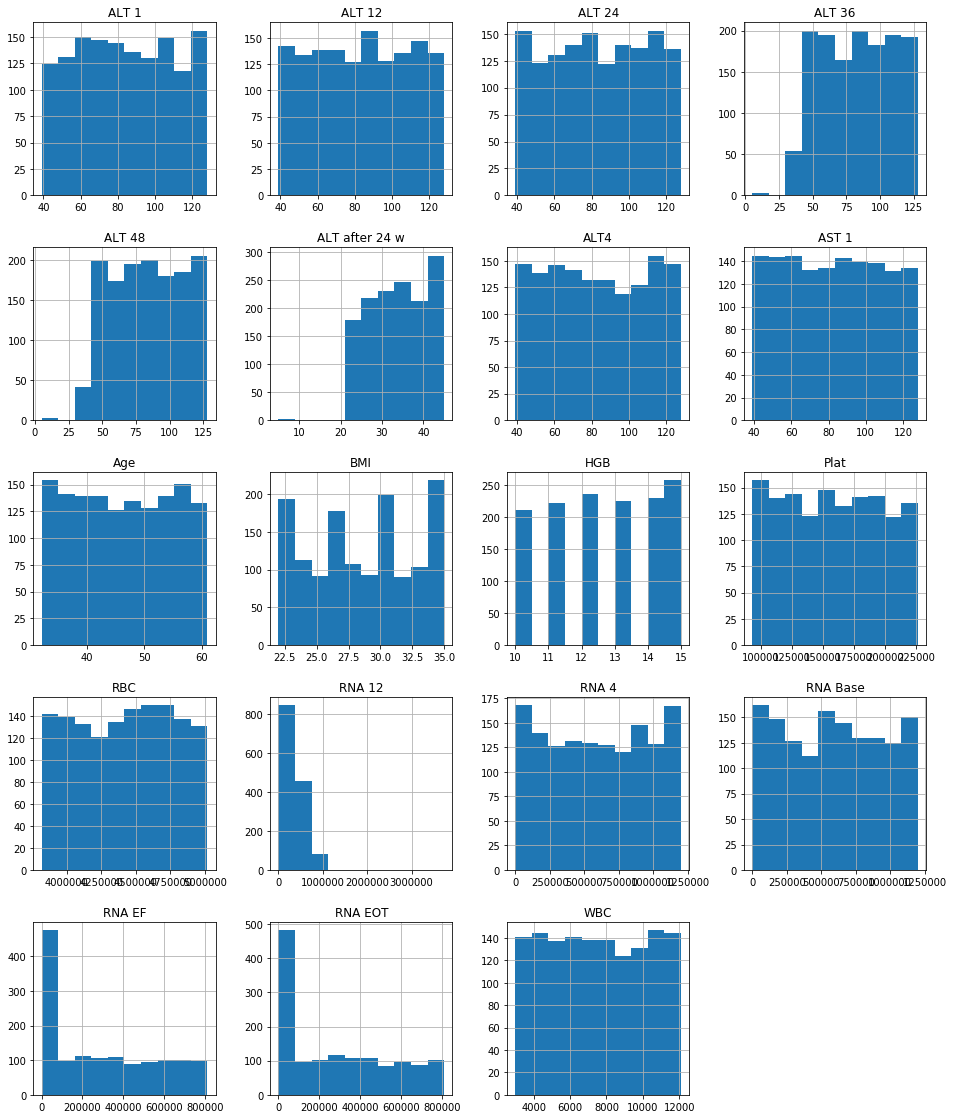

In [24]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

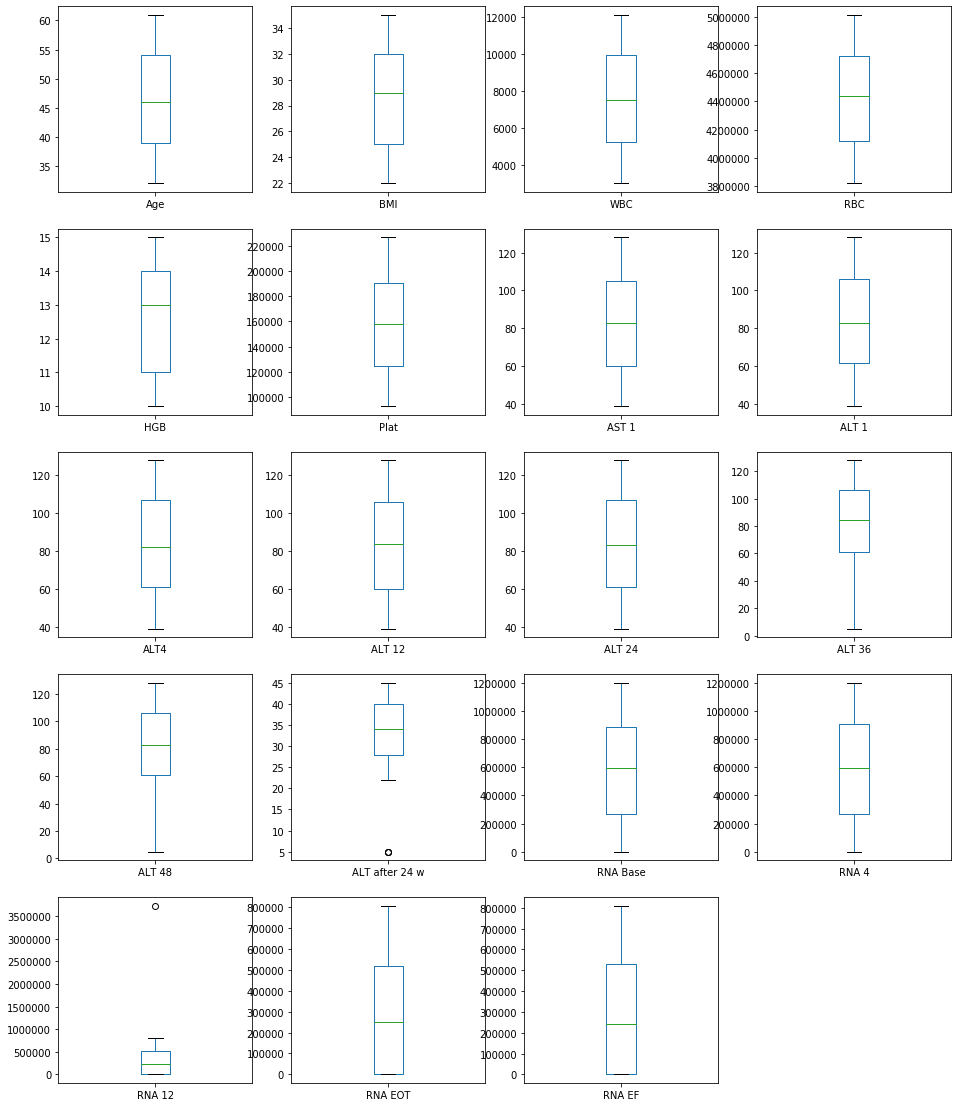

In [25]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

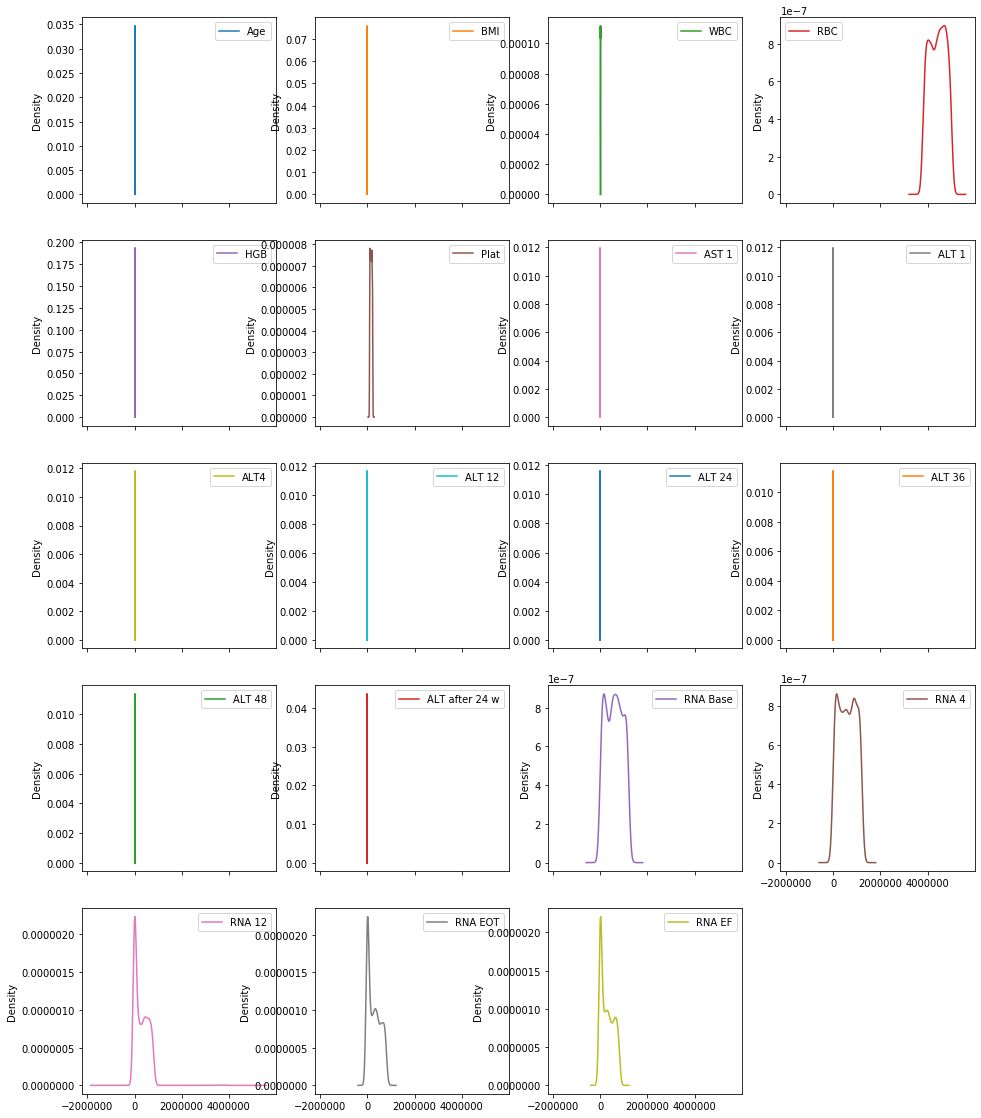

In [26]:
# Density plot for each attribute
X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [27]:
# Scatterplot matrix
# scatter_matrix(X_original)
# plt.show()

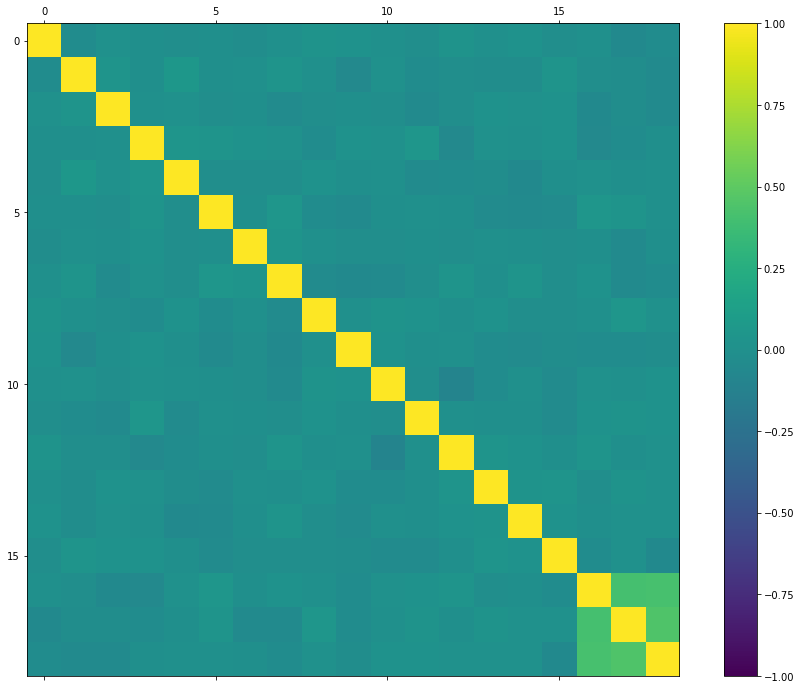

In [28]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [29]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [30]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [31]:
# Perform one-hot-encoding before splitting into trainig and test

X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 49 columns):
Age                                  1385 non-null float64
BMI                                  1385 non-null float64
WBC                                  1385 non-null float64
RBC                                  1385 non-null float64
HGB                                  1385 non-null float64
Plat                                 1385 non-null float64
AST 1                                1385 non-null float64
ALT 1                                1385 non-null float64
ALT4                                 1385 non-null float64
ALT 12                               1385 non-null float64
ALT 24                               1385 non-null float64
ALT 36                               1385 non-null float64
ALT 48                               1385 non-null float64
ALT after 24 w                       1385 non-null float64
RNA Base                             1385 non-null float64
RNA 4   

In [32]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train.shape: (1038, 49) y_train_df.shape: (1038,)
X_test_df.shape: (347, 49) y_test_df.shape: (347,)


### 3.b) Feature Scaling and Data Pre-Processing

In [33]:
# Apply feature scaling techniques

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

float_columns = X_train_df.select_dtypes(include=['float']).columns
print(float_columns)
ct = ColumnTransformer([('float_scaler', StandardScaler(), float_columns)], n_jobs=n_jobs, verbose=True)
X_train_df[float_columns] = ct.fit_transform(X_train_df[float_columns])
X_test_df[float_columns] = ct.transform(X_test_df[float_columns])
X_train_df.head(20)

Index(['Age', 'BMI', 'WBC', 'RBC', 'HGB', 'Plat', 'AST 1', 'ALT 1', 'ALT4',
       'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w', 'RNA Base',
       'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF'],
      dtype='object')


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,ALT4,ALT 12,...,Baseline histological Grading_7,Baseline histological Grading_8,Baseline histological Grading_9,Baseline histological Grading_10,Baseline histological Grading_11,Baseline histological Grading_12,Baseline histological Grading_13,Baseline histological Grading_14,Baseline histological Grading_15,Baseline histological Grading_16
1114,-0.815026,-1.125176,-0.558382,-0.721200,-0.936548,-0.202936,1.480701,0.799105,-0.613325,1.339388,...,0,0,0,0,0,0,0,1,0,0
369,0.666580,1.323320,0.857624,0.893522,0.227688,1.201286,-0.288670,1.104775,0.600606,-0.776488,...,0,0,0,1,0,0,0,0,0,0
322,1.236428,-1.125176,0.235411,0.312276,1.391924,1.071798,0.095976,-0.270737,-0.803001,0.146803,...,0,0,0,0,0,0,0,0,0,1
605,-1.270904,-0.390627,-1.443811,-1.205055,0.227688,1.635456,0.711409,-1.569830,1.586926,1.300917,...,0,0,0,0,0,0,0,0,0,1
258,0.894519,-0.635476,-1.664791,1.325059,0.227688,1.378188,-0.865638,0.187767,1.624861,0.339155,...,0,0,0,0,0,1,0,0,0,0
386,-0.131208,-0.880326,-0.357389,-0.800699,-0.354430,0.030664,-0.211740,-0.729240,-0.651260,-0.391784,...,0,0,0,0,0,0,0,0,1,0
312,0.894519,1.078470,-1.492456,-0.592489,0.809806,0.460446,-1.019496,0.569854,-1.334096,-0.699548,...,0,0,0,0,0,0,1,0,0,0
430,1.008489,0.343922,0.340621,-0.627517,-0.936548,-0.879656,0.442157,-1.378787,0.259188,-0.776488,...,0,0,0,0,0,0,0,0,0,0
1078,-1.384874,-0.390627,-0.194859,-0.849030,0.809806,-1.034675,-0.942567,-0.729240,-1.485838,1.031624,...,0,0,0,0,0,0,0,0,0,0
266,-0.473117,-0.390627,1.129889,-1.310782,-0.936548,0.645663,0.480622,-0.614614,-0.803001,1.262447,...,0,0,0,1,0,0,0,0,0,0


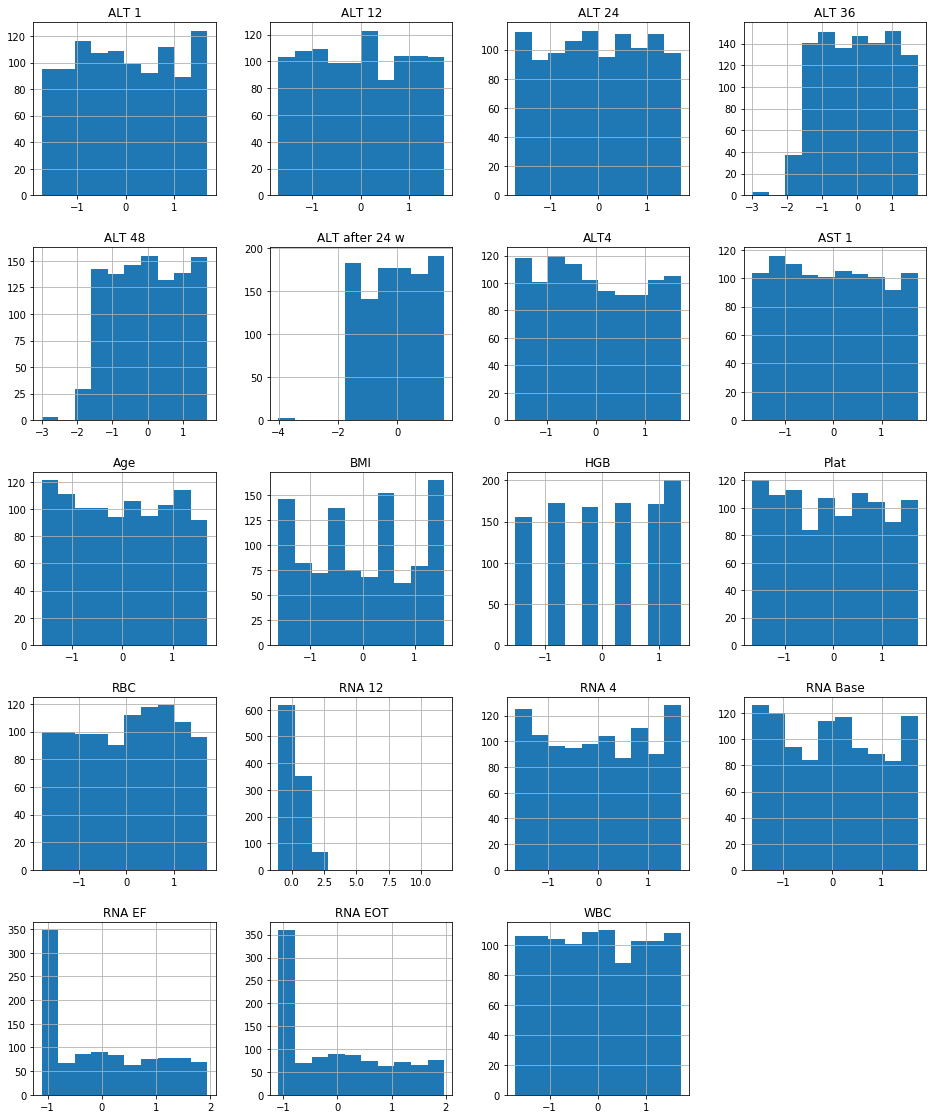

In [34]:
# Histograms for each attribute
X_train_df[float_columns].hist(layout=(dispRow,dispCol))
plt.show()

### 3.c) Feature Selection

In [35]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [36]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (1038, 49) y_train.shape: (1038,)
X_test.shape: (347, 49) y_test.shape: (347,)


In [37]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and five ensemble algorithms:

Linear Algorithm: Linear Discriminant Analysis

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged Decision Trees, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [38]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs)))

In [39]:
# Generate model in turn
for name, model in train_models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

LDA: 0.258187 (0.030328)
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Model training time: 0:00:00.314374 

CART: 0.253351 (0.036611)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=888, splitter='best')
Model training time: 0:00:00.438819 

KNN: 0.280293 (0.028177)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
Model training time: 0:00:01.610764 

BGT: 0.245650 (0.033260)
BaggingClassifier(base

### 4.b) Spot-checking baseline algorithms

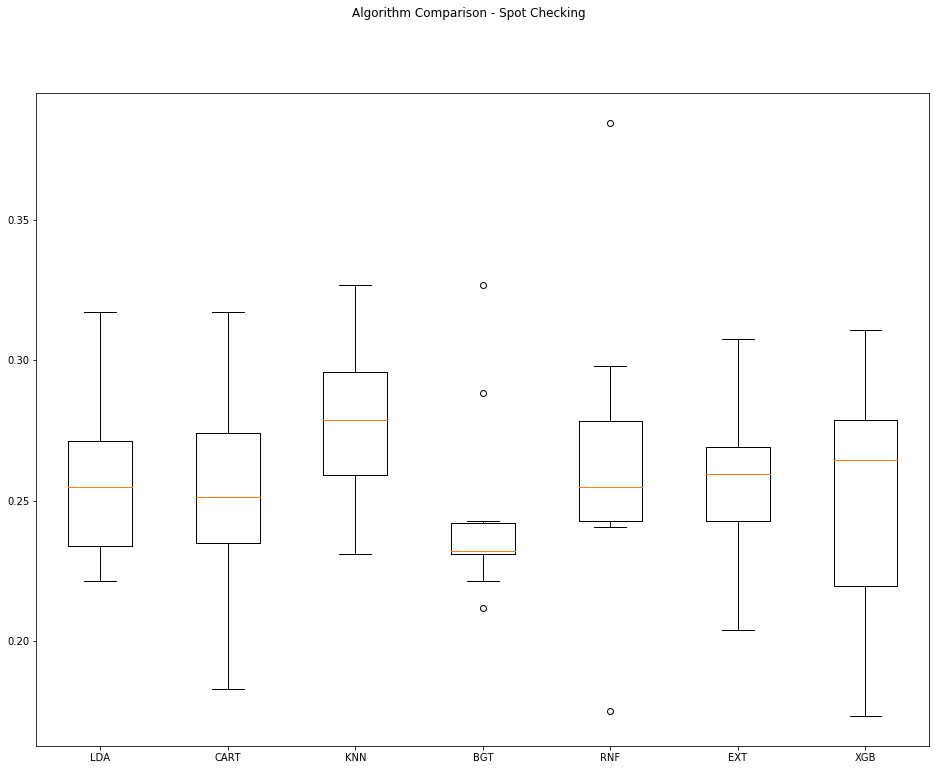

In [40]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [49]:
# Set up the comparison array
tune_results = []
tune_names = []

In [50]:
# Tuning algorithm #1 - k-Nearest Neighbors
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = KNeighborsClassifier(n_jobs=n_jobs)
tune_names.append('KNN')
paramGrid1 = dict(n_neighbors=np.array([5, 10, 15, 20, 30]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.294810 using {'n_neighbors': 15}
0.280293 (0.028177) with: {'n_neighbors': 5}
0.282207 (0.037552) with: {'n_neighbors': 10}
0.294810 (0.040299) with: {'n_neighbors': 15}
0.289890 (0.045345) with: {'n_neighbors': 20}
0.265870 (0.034833) with: {'n_neighbors': 30}
Model training time: 0:00:04.006616


In [51]:
for key, value in grid_result1.best_params_.items():
    best_paramKey1 = key
    best_paramValue1 = value
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_neighbors = 15


In [52]:
# Tuning algorithm #2 - Random Forest
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([20, 50, 75, 100, 150]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.281236 using {'n_estimators': 50}
0.244679 (0.056685) with: {'n_estimators': 20}
0.281236 (0.055488) with: {'n_estimators': 50}
0.257142 (0.050252) with: {'n_estimators': 75}
0.264862 (0.050525) with: {'n_estimators': 100}
0.265814 (0.060763) with: {'n_estimators': 150}
Model training time: 0:00:29.717922


In [53]:
for key, value in grid_result2.best_params_.items():
    best_paramKey2 = key
    best_paramValue2 = value
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 50


### 5.b) Compare Algorithms After Tuning

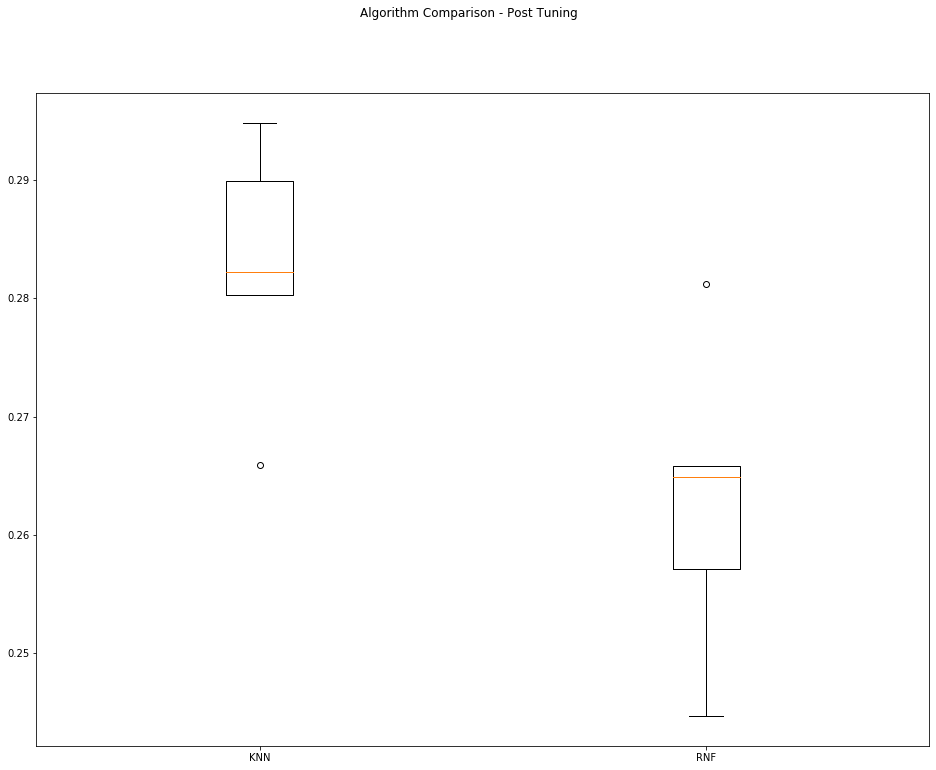

In [54]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [55]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [56]:
test_model1 = KNeighborsClassifier(n_neighbors=best_paramValue1, n_jobs=n_jobs)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 0.2478386167146974
[[21 27 18 18]
 [23 22 17 21]
 [22 26 19 22]
 [19 23 25 24]]
              precision    recall  f1-score   support

           1       0.25      0.25      0.25        84
           2       0.22      0.27      0.24        83
           3       0.24      0.21      0.23        89
           4       0.28      0.26      0.27        91

    accuracy                           0.25       347
   macro avg       0.25      0.25      0.25       347
weighted avg       0.25      0.25      0.25       347

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
                     weights='uniform')


In [57]:
test_model2 = RandomForestClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(test_model2)

Accuracy Score: 0.23054755043227665
[[12 25 26 21]
 [12 22 27 22]
 [25 24 19 21]
 [20 18 26 27]]
              precision    recall  f1-score   support

           1       0.17      0.14      0.16        84
           2       0.25      0.27      0.26        83
           3       0.19      0.21      0.20        89
           4       0.30      0.30      0.30        91

    accuracy                           0.23       347
   macro avg       0.23      0.23      0.23       347
weighted avg       0.23      0.23      0.23       347

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=Fa

### 6.b) Create a standalone model using all available data

In [58]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
finalModel = test_model1

X_complete.shape: (1385, 49) y_complete.shape: (1385,)


### 6.c) Save the final model for later use

In [59]:
# modelName = 'finalModel_MultiClass.sav'
# dump(finalModel, modelName)

In [60]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [61]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:41.356288
